# Imports

In [1]:
import arviz as az
from cmdstanpy import install_cmdstan, CmdStanModel

import matplotlib.pyplot as plt
import numpy as np
from os import mkdir
from os.path import exists, isdir

import pandas as pd
import scipy as sp
from tqdm import tqdm as tqdm

In [2]:
# This can take a few minutes, so consider running it now then tabbing back
install_cmdstan()

Installing CmdStan version: 2.32.2
Install directory: /home/hjhornbeck/.cmdstan
CmdStan version 2.32.2 already installed


True

# Global Variables / Methods

In [3]:
data_file  = 'data/calgary_population.csv.bz2'
model_file = 'models/template_model.stan'

# create some useful directories
for directory in ['data','derived','models','posteriors']:
    if not isdir(directory):
        mkdir(directory)

rng = np.random.default_rng(42)

# Data

In [4]:
# if it hasn't been cached, download it!
if not exists( data_file ):
    
    dataset = pd.read_csv( 'https://data.calgary.ca/api/views/rmai-qvzh/rows.csv?accessType=DOWNLOAD' )
    dataset.to_csv( data_file, index=False )

dataset = pd.read_csv( data_file )
cleaned = dataset.drop( ['Ward','Vehicles','Age 65 +','Voters','CENSUS_YEAR'], axis=1 \
                      ).groupby(['Year']).sum().reset_index()

cleaned

Year  Dwellings  Residents
0   1958    64288.0     206831
1   1959        0.0     218418
2   1960    72987.0     235428
3   1961        0.0     241673
4   1962    81610.0     269068
..   ...        ...        ...
57  2015   492623.0    1230915
58  2016   499222.0    1235171
59  2017   506392.0    1246337
60  2018   515391.0    1267344
61  2019   521257.0    1285711

[62 rows x 3 columns]

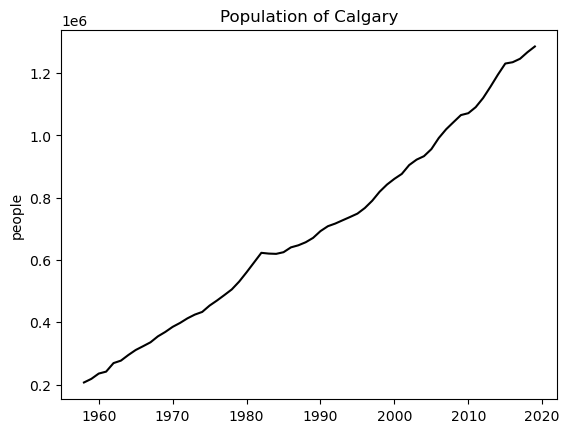

In [5]:
plt.plot( cleaned.Year, cleaned.Residents, '-k', label='data')
plt.title("Population of Calgary")
plt.ylabel('people')
plt.show()

# Model

In [6]:
stan_code = '''
data {
  int n;       // number of datapoints
  vector[n] X; // the X and Y values of those datapoints
  vector[n] Y;
}
parameters {
  real m;              // slope
  real b;              // intercept
  real<lower=0> sigma; // standard deviation
}
model {
  vector[n] Y_hat = X*m + b;
  Y ~ normal( Y_hat, sigma );
}
'''

with open(model_file,'wt') as file:
  file.write(stan_code)

In [7]:
model = CmdStanModel(stan_file=model_file, cpp_options={'STAN_THREADS': 'TRUE'})

11:53:11 - cmdstanpy - INFO - compiling stan file /home/hjhornbeck/school/graduate/presentations/probabilistic_programming_2023/models/template_model.stan to exe file /home/hjhornbeck/school/graduate/presentations/probabilistic_programming_2023/models/template_model
11:53:39 - cmdstanpy - INFO - compiled model executable: /home/hjhornbeck/school/graduate/presentations/probabilistic_programming_2023/models/template_model


In [8]:
data = {'n':len(cleaned), 'X':list(cleaned.Year), 'Y':list(cleaned.Residents)} # must be serializable!

# Sampling

In [9]:
fit = model.sample( data=data )

11:53:39 - cmdstanpy - INFO - CmdStan start processing
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


11:53:39 - cmdstanpy - ERROR - Error in progress bar initialization:
	'FloatProgress' object has no attribute 'style'
Disabling progress bars for this session


11:53:43 - cmdstanpy - INFO - CmdStan done processing.
11:53:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 iterations at max treedepth (0.9%)
	Chain 3 had 41 iterations at max treedepth (4.1%)
	Chain 4 had 29 iterations at max treedepth (2.9%)
	Use function "diagnose()" to see further information.


# Diagnostics

In [10]:
print( fit.diagnose() );

Processing csv files: /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_1.csv, /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_2.csv, /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_3.csv, /tmp/tmpf8tmvs1c/template_modeldo6ondkn/template_model-20230602115339_4.csv

Checking sampler transitions treedepth.
79 of 4000 (1.98%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [11]:
fit.summary()

Mean          MCSE        StdDev            5%           50%  \
lp__  -6.662920e+02      0.032898       1.14629 -6.685780e+02 -6.660230e+02   
m      1.728940e+04      7.410140     233.94200  1.689770e+04  1.728430e+04   
b     -3.368270e+07  14732.800000  465322.00000 -3.447050e+07 -3.367270e+07   
sigma  3.366380e+04     82.452400    3113.73000  2.885660e+04  3.345740e+04   

                95%     N_Eff  N_Eff/s    R_hat  
lp__  -6.649740e+02  1214.120  149.744  1.00218  
m      1.768600e+04   996.697  122.928  1.00382  
b     -3.290720e+07   997.558  123.034  1.00379  
sigma  3.894520e+04  1426.110  175.890  1.00178

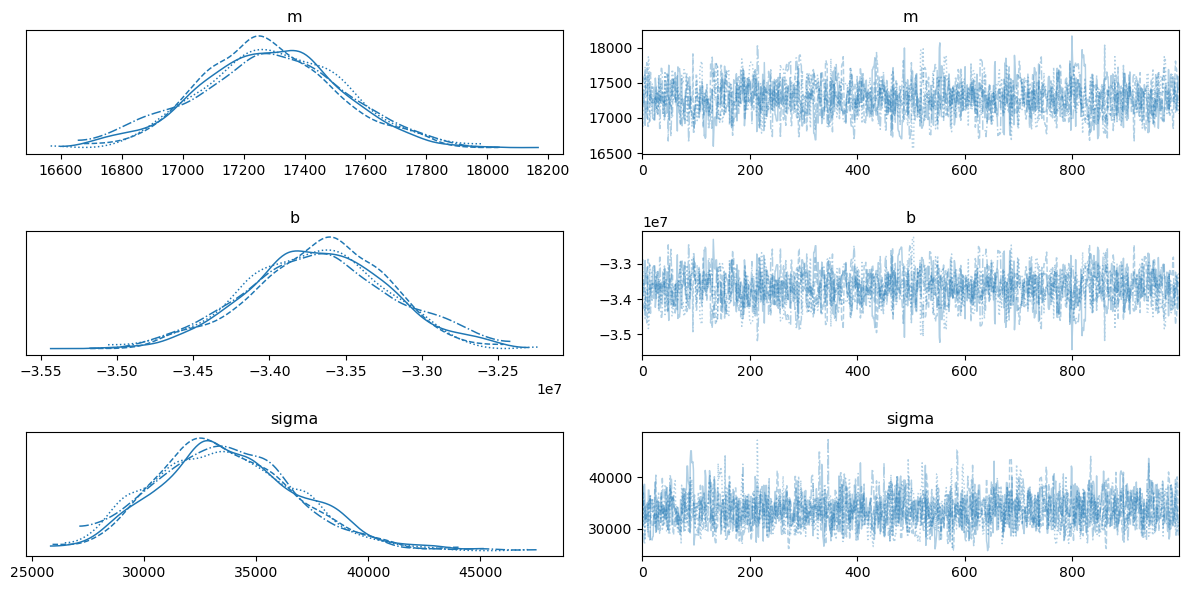

In [12]:
az.plot_trace( fit );
plt.tight_layout()

Exception ignored in: <function tqdm.__del__ at 0x7fe0014a0040>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 160, in display
    d = self.format_dict
        ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/tqdm/std.py", line 1476, in format_dict
    'colour': self.colour}
              ^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 204, in colour
    return self.container.children[-2].style.bar_color
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'FloatProgress' object has no attribute 'style'


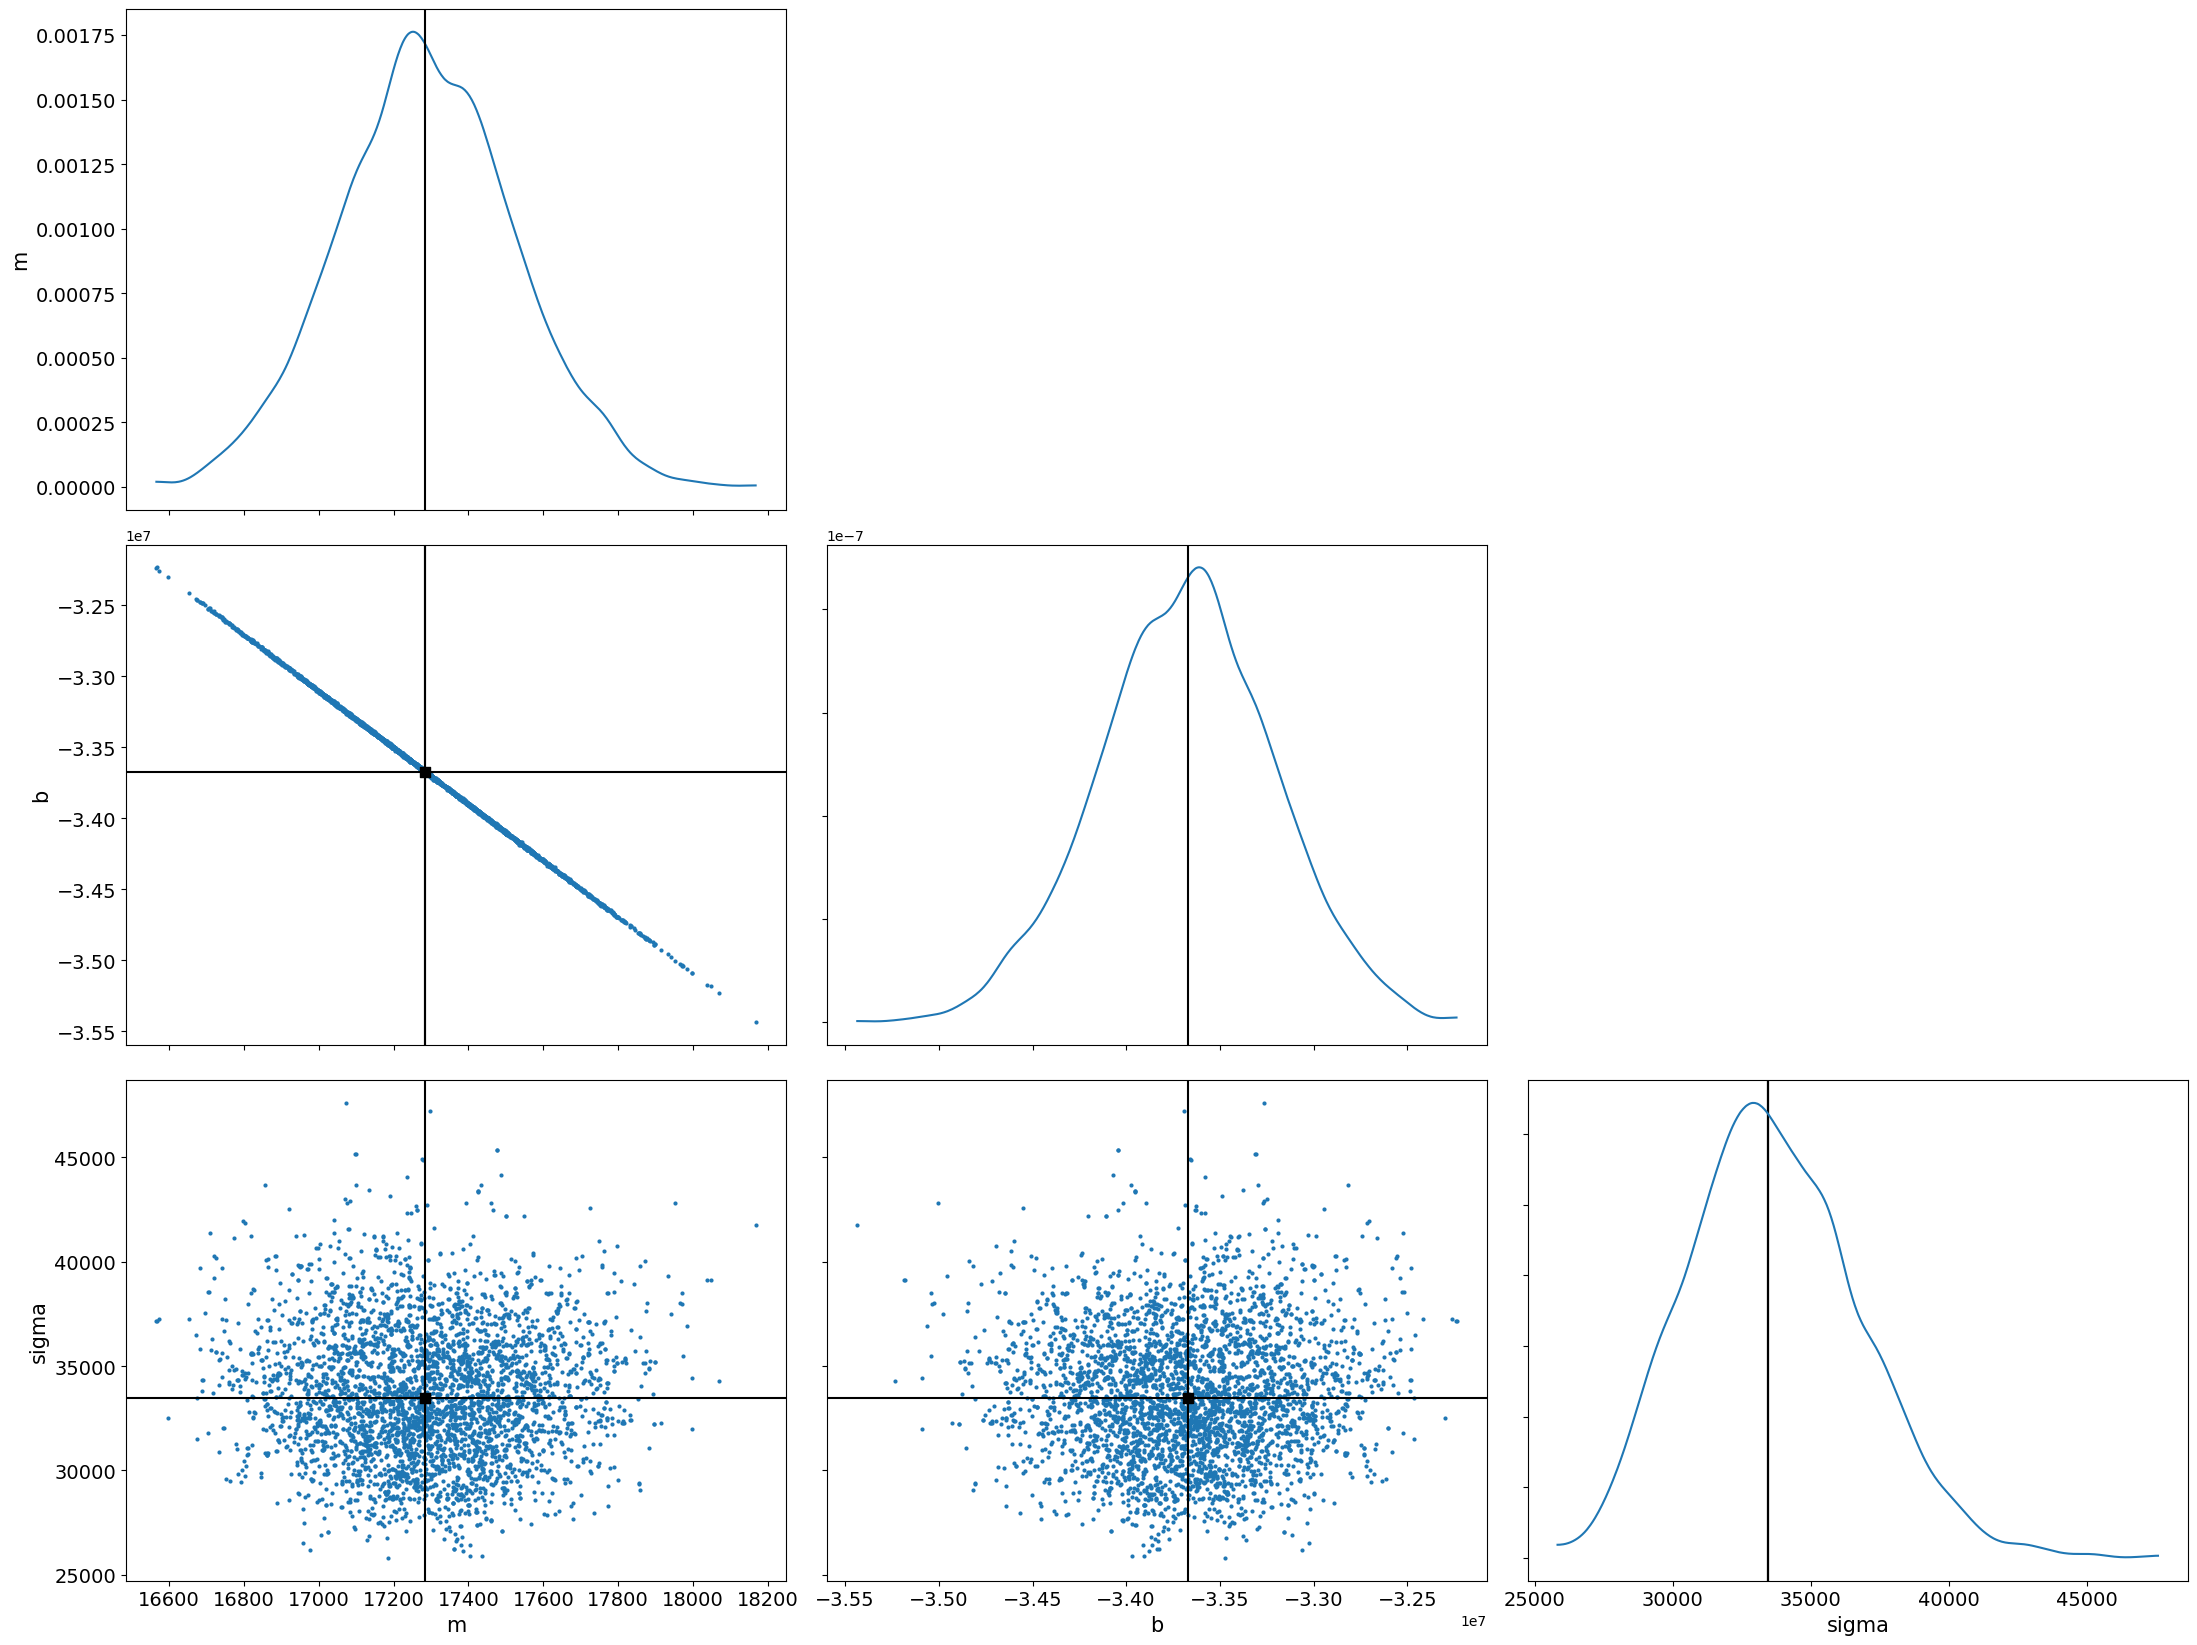

In [15]:
az.plot_pair( fit, marginals=True, point_estimate="median" );
plt.tight_layout()

# Results

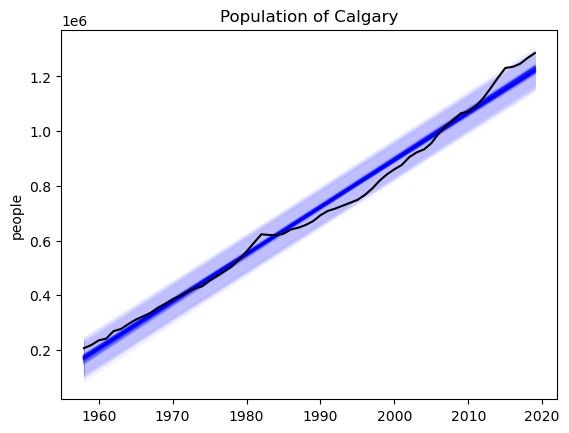

In [14]:
X = np.array( [min(data['X']), max(data['X'])] )

for idx in rng.choice( len(fit.stan_variable('m')), size=64 ):
  model = fit.stan_variable('m')[idx]*X + fit.stan_variable('b')[idx]
  plt.plot( X, model, '-b', alpha=.1 )
  plt.fill_between( X, model - 1.96*fit.stan_variable('sigma')[idx], model + 1.96*fit.stan_variable('sigma')[idx], color='blue', alpha=.005 )

plt.plot( data['X'], data['Y'], '-k', label='data')
plt.title("Population of Calgary")
plt.ylabel('people')
plt.show()